In [9]:
%matplotlib widget 
import os 
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import shapely.geometry 
from shapely import Point
from pyproj import CRS
plt.ion()

In [2]:
# function to assign and project correct CRS
def set_and_reproj(gdf, current_epsg=4326, target_epsg=32629):
    '''
    Assigns current epsg to a GeoDataFrame if missing, then reprojects it to target CRS.

    Parameters:
    -----------
    - gdf: GeoDataFrame
    - current_epsg: EPSG code of current CRS (default: 4326)
    - target_epsg: EPSG code to reproject to (default: 32629)

    Returns:
    --------
    - Reprojected GeoDataFrame
    '''
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=current_epsg)
        
    return gdf.to_crs(epsg=target_epsg)
    

In [3]:
# define generate handles function
def generate_handles(labels, colors, edge='k', alpha=1):
    
    '''
    Generate matplotlib handles to create a legend for each feature on the map.

    Parameters
    ----------

    labels: list(str) - text labels of features to show on legend.
    colors: list(matplotlib color) - colors used for each feature on map.
    edge: matplotlib color (default: 'k') - color to use for edge of legend patches
    alpha: float (default: 1.0) - alpha value to use for legend patches

    Returns
    -------

    handles: list(matplotlib.patches.Rectangle) - list of legend patches to pass to ax.legend()

    '''
    lc = len(colors) # gets length of colour list
    handles = [] # create an empty list
    for ii in range(len(labels)): # for each label/colour pair, make an empty box for legend
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[ii % lc], edgecolor = edge, alpha=alpha))
    return handles

In [4]:
def scale_bar(ax, length=20, location=(0.92, 0.95)):
    """
    Create a scale bar in a cartopy GeoAxes.

    Parameters
    ----------

    ax : cartopy.mpl.geoaxes.GeoAxes
        the cartopy GeoAxes to add the scalebar to.

    length : int, float (default 20)
        the length of the scalebar, in km

    location : tuple(float, float) (default (0.92, 0.95))
        the location of the center right corner of the scalebar, in fractions of the axis.

    Returns
    -------
    ax : cartopy.mpl.geoaxes.GeoAxes
        the cartopy GeoAxes object

    """
    x0, x1, y0, y1 = ax.get_extent() # get the current extent of the axis
    sbx = x0 + (x1 - x0) * location[0] # get the right x coordinate of the scale bar
    sby = y0 + (y1 - y0) * location[1] # get the right y coordinate of the scale bar

    ax.plot([sbx, sbx-length*1000], [sby, sby], color='k', linewidth=4, transform=ax.projection) # plot a thick black line
    ax.plot([sbx-(length/2)*1000, sbx-length*1000], [sby, sby], color='w', linewidth=2, transform=ax.projection) # plot a white line from 0 to halfway

    ax.text(sbx, sby-(length/4)*1000, f"{length} km", ha='center', transform=ax.projection, fontsize=6) # add a label at the right side
    ax.text(sbx-(length/2)*1000, sby-(length/4)*1000, f"{int(length/2)} km", ha='center', transform=ax.projection, fontsize=6) # add a label in the center
    ax.text(sbx-length*1000, sby-(length/4)*1000, '0 km', ha='center', transform=ax.projection, fontsize=6) # add a label at the left side

    return ax

In [5]:
def simpsons_diversity(abundances):
    """
    Calculate Simpson's Diversity indices from species abundances.

    Parameters:
    -----------
    abundances : array-like
        List or array of species abundances

    Returns:
    --------
    dict : Dictionary containing D, 1-D, and 1/D
    """
    abundances = np.array(abundances)
    total = abundances.sum()
    proportions = abundances / total
    D = np.sum(proportions ** 2)

    return {
        'D': D,
        '1-D': 1 - D,
        '1/D': 1 / D
    }


# function copied from The Research Scientist Pod (2024) Available at: https://researchdatapod.com/simpsons-diversity-index/ 

In [6]:
# read in files and data
outline = set_and_reproj(gpd.read_file('data_files/NI_outline.shp'), current_epsg=4326)
towns = set_and_reproj(gpd.read_file('data_files/Towns.shp'), current_epsg=4326)
counties = set_and_reproj(gpd.read_file('data_files/Counties.shp'), current_epsg=4326)
water = set_and_reproj(gpd.read_file('data_files/Water.shp'), current_epsg=4326)
aonb = set_and_reproj(gpd.read_file('data_files/AONB.shp'), current_epsg=4326)
assi = set_and_reproj(gpd.read_file('data_files/ASSI.shp'), current_epsg=4326)

In [7]:
# read in NBN csv file
lepi = pd.read_csv('data_files/egm722_project_data_NBN.csv')

In [10]:
# convert the lepi DataFrame to a GeoDataFrame
lepi['geometry'] = list(zip(lepi['Longitude (WGS84)'], lepi['Latitude (WGS84)'])) # create geometry column using lat/long columns and zip together
lepi['geometry'] = lepi['geometry'].apply(Point) # turn the geometry column into points

del lepi['Longitude (WGS84)'], lepi['Latitude (WGS84)'], lepi['Data provider'] # remove unwanted columns
lepi = lepi.rename(columns={'Scientific name': 'sci_name', 'Common name': 'com_name', 'Start date': 'date'}) # rename columns
lepi = gpd.GeoDataFrame(lepi, geometry='geometry') # create the new GeoDataFrame

lepi = set_and_reproj(lepi) # use set and reproject function to modify crs

In [11]:
lepi.to_file('lepi_points.shp') # save to shapefile

In [12]:
# spatially join lepi points to counties data frame
lepi_join_counties = gpd.sjoin(lepi, counties[['CountyName', 'geometry']], how='inner', predicate='within')

In [13]:
ni_utm = ccrs.UTM(29) # create lat/long reference system to transform data

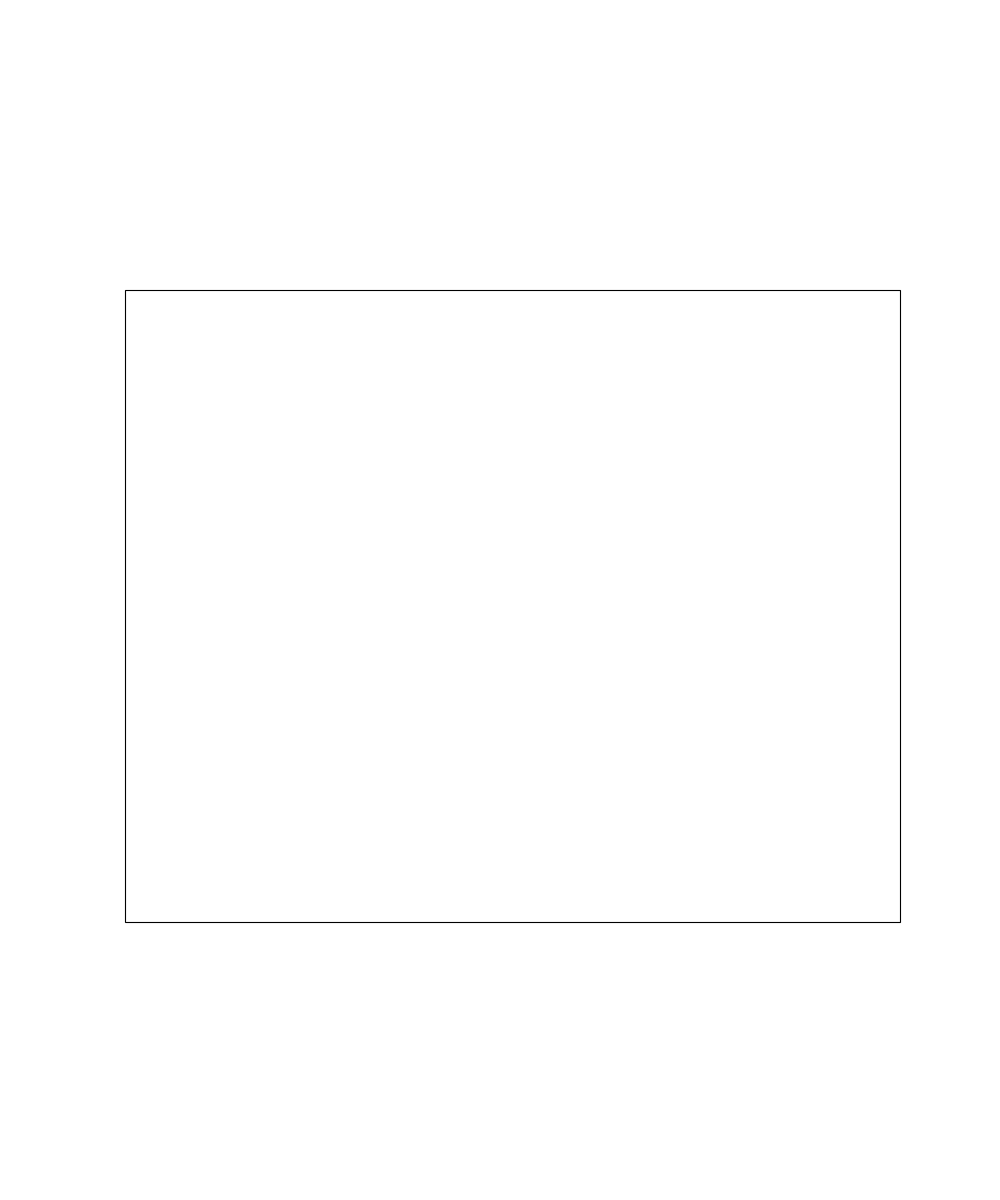

In [14]:
fig, ax = plt.subplots(figsize=(10, 12), subplot_kw={'projection': ni_utm})  # create a figure 10x12 (page size in inches) and an axis object in the figure using utm projection

xmin, ymin, xmax, ymax = outline.total_bounds # using boundary of outline features, zooms map to NI
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=ni_utm) # reordered coordinates for set_extent

In [15]:
# add NI outline to map
outline_feature = ShapelyFeature(outline['geometry'], ni_utm, edgecolor='k', facecolor='w') 

outline['area_km2'] = outline.geometry.area / 1e6 # add and calculate area in square km from geometry column
del outline['area'] # delete old area column

ax.add_feature(outline_feature)

In [16]:
# get the number of unique counties in the dataset
num_counties = len(counties.CountyName.unique())
print(f'Number of unique features: {num_counties}') 

Number of unique features: 6


In [17]:
# add counties to the map
county_colors = ['#b35806','#f1a340','#fee0b6','#d8daeb','#998ec3','#542788'] # pick colours for individual counties

# get a list of unique names for the county boundaries
county_names = list(counties.CountyName.unique())
county_names.sort() # sort counties alphabetically by name

# next, add the municipal outlines to the map using the colors that we've picked.
# here, we're iterating over the unique values in the 'CountyName' field.
# we're also setting the edge color to be black, with a line width of 0.5 pt.
# Feel free to experiment with different colors and line widths.
for ii, name in enumerate(county_names):
    feat = ShapelyFeature(counties.loc[counties['CountyName'] == name, 'geometry'], # first argument is the geometry
                          ccrs.CRS(counties.crs), # second argument is the CRS
                          edgecolor='k', # outline feature in black
                          facecolor=county_colors[ii], # set the face color to the corresponding color from the list
                          linewidth=1, # set the outline width to be 1 pt
                          alpha=0.2) # set the alpha (transparency) to be 0.4 (out of 1)
    ax.add_feature(feat) # once we have created the feature, we have to add it to the map using ax.add_feature()

In [18]:
assi = ShapelyFeature(assi['geometry'],
                      ni_utm,
                      edgecolor='k',
                      facecolor='lawngreen',
                      linewidth=0.7)
ax.add_feature(assi)

In [19]:
aonb = ShapelyFeature(aonb['geometry'],
                      ni_utm,
                      edgecolor='k',
                      facecolor='green',
                      linewidth=0.7,
                     alpha=0.4)
ax.add_feature(aonb)

In [20]:
# add the water features with single colour symbology
lakes  = ShapelyFeature(water['geometry'],
                            ni_utm,
                            edgecolor='royalblue',
                            facecolor='royalblue', 
                            linewidth=1)
ax.add_feature(lakes)

In [21]:
# add towns
towns_handle = ax.plot(towns.geometry.x, towns.geometry.y, 'o', color='k', ms=6)

C:\Users\byg-l\anaconda\envs\project_env\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


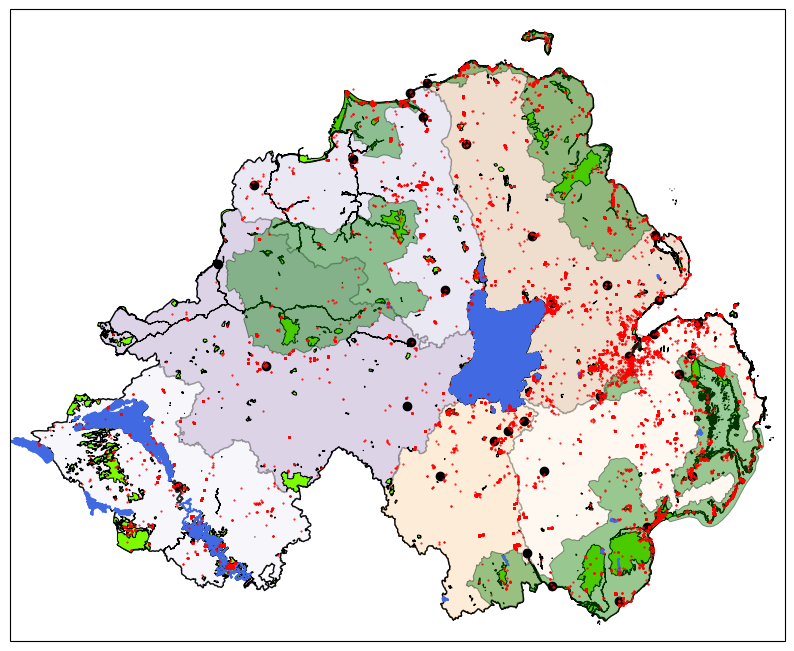

In [22]:
# add lepi points
lepi_handle = ax.plot(lepi.geometry.x, lepi.geometry.y, 'o', color='red', ms=0.5)
fig

In [23]:
# generate a list of handles for the datasets
# add list of names, colors, and set transparency
county_handle = generate_handles(counties.CountyName.unique(), county_colors, alpha=0.4)
aonb_handle = generate_handles(['aonb'], ['green'], alpha=0.4)
assi_handle = generate_handles(['assi'], ['lawngreen'])
water_handle = generate_handles(['lakes'], ['royalblue'])

In [24]:
# update county_names to take it out of uppercase text
nice_names = []  # initalize an empty list
for name in county_names:
    nice_names.append(name.title())

In [25]:
# adds legend to map, using handles and labels corresponding to the objects

handles = county_handle + water_handle + assi_handle + aonb_handle + towns_handle + lepi_handle # use '+' to concatenate (combine) lists
labels = nice_names + ['Lakes', 'ASSI', 'AONB', 'Towns', 'Species Occurrence']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                 fontsize=10, loc='upper left', frameon=True, framealpha=1)

In [26]:
# adds gridlines with labels at 0.5 degree intervals
gridlines = ax.gridlines(draw_labels=True, # draw  labels for the grid lines
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5], # add longitude lines at 0.5 deg intervals
                         ylocs=[54, 54.5, 55, 55.5]) # add latitude lines at 0.5 deg intervals
gridlines.left_labels = False # turn off the left-side labels
gridlines.bottom_labels = False # turn off the bottom labels

In [27]:
scale_bar(ax) # place the scale bar from function above, in upper right corner of the map

<GeoAxes: >

C:\Users\byg-l\anaconda\envs\project_env\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\byg-l\anaconda\envs\project_env\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


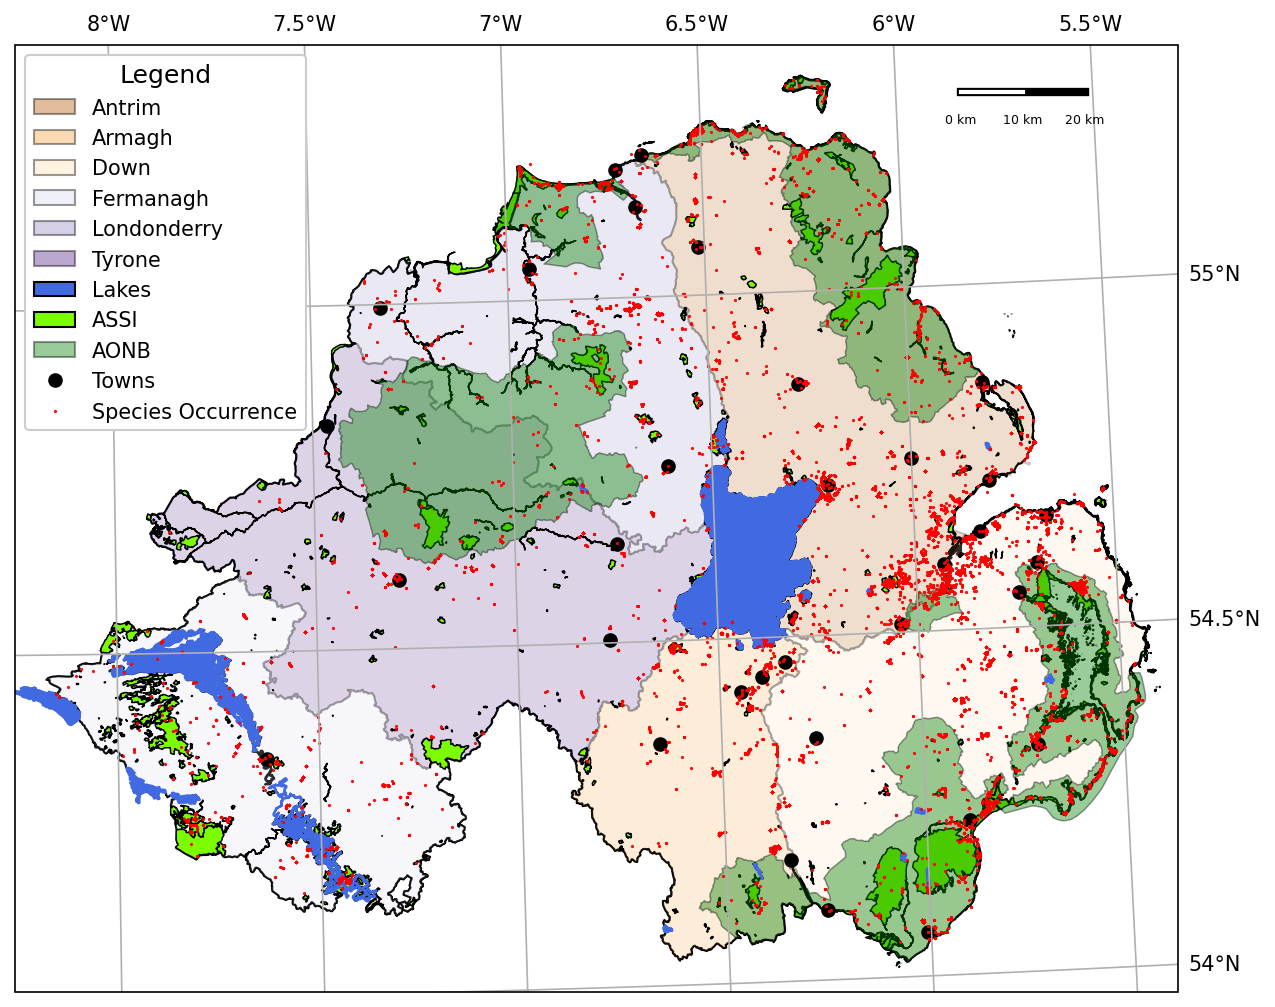

In [30]:
for ind, row in towns.iterrows(): # towns.iterrows() returns the index and row
    x, y = row.geometry.x, row.geometry.y # get the x,y location for each town
    ax.text(x, y, row['TOWN_NAME'].title(), fontsize=7, transform=ccrs.PlateCarree()) # use plt.text to place a label at x,y

fig # to show the updated figure

In [31]:
fig.savefig('map.png', bbox_inches='tight', dpi=300)

C:\Users\byg-l\anaconda\envs\project_env\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\byg-l\anaconda\envs\project_env\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


abundances = lepi['sci_name'].value_counts().values  # Our lepidoptera example
results = simpsons_diversity(abundances)
print(f"Simpson's Dominance (D): {results['D']:.3f}")
print(f"Simpson's Diversity (1-D): {results['1-D']:.3f}")
print(f"Simpson's Reciprocal (1/D): {results['1/D']:.3f}")

richness = lepi['sci_name'].nunique() # counts the number of unique species
print(richness)